# Reinforced Concrete Frame Analysis

This notebook explains the analysis of the reinforced concrete frame shown below using OpenSeesPy. The frame will be analysed using gravity load analysis, pushover analysis and earthquake analysis. The example is scourced from the OpenSees wiki [here](https://opensees.ist.berkeley.edu/wiki/index.php?title=Reinforced_Concrete_Frame_Example). The code used in the notebook is a modified version of the scripts provided in the OpenSeesPy doucmentation [here](https://openseespydoc.readthedocs.io/en/latest/src/RCFrameGravity.html). This notebook will also introduce the use of the 'opsvis' module. The documentation for this module can be found [here](https://opsvis.readthedocs.io/en/latest/). It is advisable for the reader to use this module in when they tackle problems using OpenSeesPy in the future. The module is very simple to use, is excellent for problem visualisation and understanding what is happening in each step. 


## Diagram

![alt text](<Reinforced concrete frame diagram.PNG>)

Below the required modules are imported and important variables are defined

In [ ]:
import openseespy.opensees as ops
import numpy as np
import opsvis as opsv
import matplotlib.pyplot as plt
import os

#Units
m = 1
N = 1
Pa = 1

inches = 0.0254*m
ft = 12*inches
kip = 4.45*10**3*N
ksi = 6.89*10**6*Pa

# Portal frame dimensions
width = 30*ft
height = 12*ft

# Column dimensions
colWidth = 15*inches
colDepth = 24*inches

# Steel reinforcement
cover = 1.5*inches
As = (0.60*inches)**2  # area of no. 7 bars
fy = 60.0;  # Yield stress
E = 30000.0;  # Young's modulus

# Column centrelines
y1 = colDepth / 2.0
z1 = colWidth / 2.0

# Beam properties
A_beam = 360.0
E_beam = 4030.0
Iz_beam = 8640.0

# Set deflection tolerance
tol = 1e-6

## Model Definition

This code blocks executes the model definition, creates notes and sets boundry conditions. Refer to basic truss example notebook for explaination of these commands. Then the 'plot_model' command from the opsvis module is used to plot model as it stands.

Starting RCFrameGravity example


Text(0.5, 1.0, 'Plot model nodes')

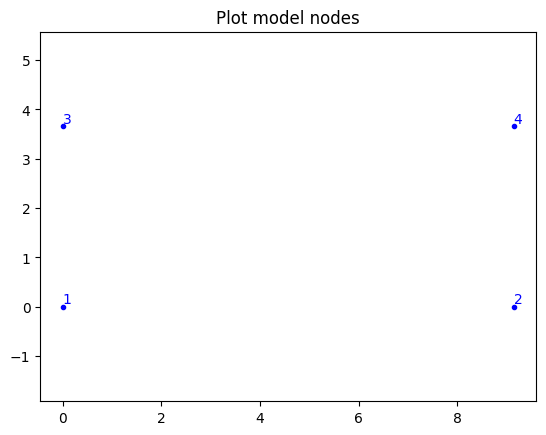

In [ ]:
ops.wipe()

#Create file path for data output
if not os.path.exists('Data'):
    os.mkdir('Data')

print("==========================")
print("Starting RCFrameGravity example")

# Model Definition
# ----------------

# Create ModelBuilder (with two-dimensions and 3 DOF/node)
ops.model('basic', '-ndm', 2, '-ndf', 3)

# Create nodes
#         tag, X, Y
ops.node(1, 0.0, 0.0)
ops.node(2, width, 0.0)
ops.node(3, 0.0, height)
ops.node(4, width, height)

# Fix supports at base of columns
#   tag, DX, DY, RZ
ops.fix(1, 1, 1, 1)
ops.fix(2, 1, 1, 1)

#Plot the model
opsv.plot_model()
plt.title('Plot model nodes')

Shown below is the material definition. Refer to basic truss example notebook for explaination of uniaxialMaterial command.

In [ ]:
# Define materials for nonlinear columns
# ------------------------------------------

# CONCRETE                        tag  f'c    ec0    f'cu   ecu
# Core concrete (confined)
ops.uniaxialMaterial('Concrete01', 1, -6.0, -0.004, -5.0, -0.014)

# Cover concrete (unconfined)
ops.uniaxialMaterial('Concrete01', 2, -5.0, -0.002, 0.0, -0.006)

# STEEL                        tag  fy E0    b
ops.uniaxialMaterial('Steel01', 3, fy, E, 0.01)


Shown below is the definition of the column cross-section. The cross-section was both defined and plotted using the opsvis module. To do so, a list of lists (fib_sec_1) was created which defines list of OpenSeesPy commands. Each list, within the list of lists, defines the command 'type' and then all of the command inputs. The list of lists is then used to plot the section using the opsvis 'plot_fibre_section' command. Then the list of lists is changed to OpenSeesPy commands using the opsvis 'fib_sec_list_to_cmds' command. This executes the commands as they would be is called using OpenSeesPy. 

The standard way of defining the section using OpenSeesPy is shown in the commented out code below. The 'section' command with command type 'Fiber' allows the creation of a Fiber Section object. A fiber section object is a cross-section that changes across defined boundries. In the case of this example, the cross-section differs in the 'confined conrete' reigon in comparison to the 'cover concrete' reigon. These reigons are defined by the placement of reinforcement within the cross-section. These reigons are defined in OpenSeesPy using the 'patch' command. By using the patch command type 'rect' a number of rectangular shaped fibers are created within a reigon of the Fibre Section that you define. In the case of this example, one rectangle reigon is used to defined the core concrete (plotted in red), and four rectangle reigons are used to define the surrounding cover concrete (plotted in light grey). These reigon can be split up into numerous fibers as seen in the patch command documentation [here](https://openseespydoc.readthedocs.io/en/latest/src/patch.html). 

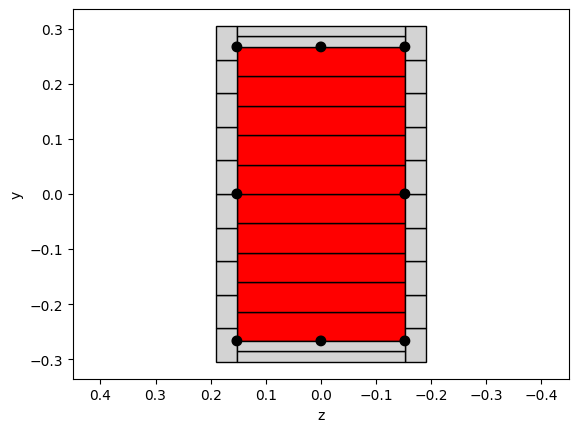

In [ ]:
# Define cross-section for nonlinear columns
# ------------------------------------------

ops.section('Fiber', 1)

# Create the concrete core fiber
ops.patch('rect', 1, 10, 1, cover - y1, cover - z1, y1 - cover, z1 - cover)

# Create the concrete cover fibers (top, bottom, left, right)
ops.patch('rect', 2, 10, 1, -y1, z1 - cover, y1, z1)
ops.patch('rect', 2, 10, 1, -y1, -z1, y1, cover - z1)
ops.patch('rect', 2, 2, 1, -y1, cover - z1, cover - y1, z1 - cover)
ops.patch('rect', 2, 2, 1, y1 - cover, cover - z1, y1, z1 - cover)

# Create the reinforcing fibers (left, middle, right)
ops.layer('straight', 3, 3, As, y1 - cover, z1 - cover, y1 - cover, cover - z1)
ops.layer('straight', 3, 2, As, 0.0, z1 - cover, 0.0, cover - z1)
ops.layer('straight', 3, 3, As, cover - y1, z1 - cover, cover - y1, cover - z1)

# Plot the fibre section
fib_sec_1 = [['section', 'Fiber', 1, '-GJ', 1.0e6],
             ['patch', 'rect', 1, 10, 1, cover - y1, cover - z1, y1 - cover, z1 - cover],  # core concrete
             ['patch', 'rect', 2, 10, 1, -y1, z1 - cover, y1, z1],  # top cover
             ['patch', 'rect', 2, 10, 1, -y1, -z1, y1, cover - z1],  # bottom cover
             ['patch', 'rect', 2, 2, 1, -y1, cover - z1, cover - y1, z1 - cover],  # left cover
             ['patch', 'rect', 2, 2, 1, y1 - cover, cover - z1, y1, z1 - cover],  # right cover 
             ['layer','straight', 3, 3, As, y1 - cover, z1 - cover, y1 - cover, cover - z1], # Left layer of steel reinforcement
             ['layer','straight', 3, 2, As, 0.0, z1 - cover, 0.0, cover - z1], # Middle layer
             ['layer','straight', 3, 3, As, cover - y1, z1 - cover, cover - y1, cover - z1] #right layer
             ]            

matcolor = ['r', 'lightgrey']
opsv.plot_fiber_section(fib_sec_1, matcolor=matcolor)
plt.axis('equal')
plt.show()

opsv.fib_sec_list_to_cmds(fib_sec_1)

Shown below is the definiton and plotting of elements. The geomTransf command is used to construct a cooridinate transformation object???? when should you use which type ????. The 'beamIntegration command selects the numerical integration algorithm that will be used to solve the problem, in this case Guass-Lobatto. 

<Axes: >

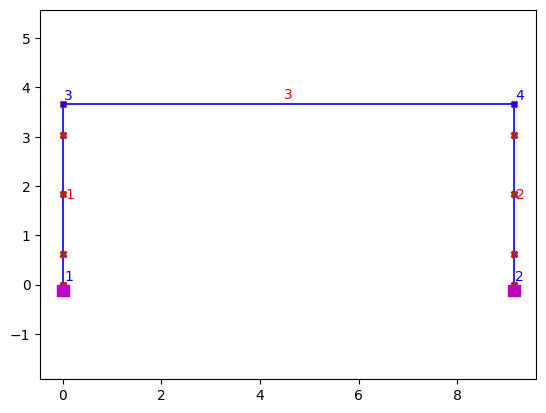

In [ ]:
# Define column elements
# ----------------------

# Geometry of column elements
#                type   tag
ops.geomTransf('PDelta', 1)

# Number of integration points along length of element
np = 5

# Lobatto integration
#              type  integrationTag  sectionTag  np
ops.beamIntegration('Lobatto', 1, 1, np)

# Create the coulumns using Beam-column elements
#            type tag elenodes() transfTag integrationTag
eleType = 'forceBeamColumn'
ops.element(eleType, 1, 1, 3, 1, 1)
ops.element(eleType, 2, 2, 4, 1, 1)


# Define beam element
# -----------------------------

# Geometry of column elements
#                type   tag
ops.geomTransf('Linear', 2)

# Create the beam element
#                              tag  elenodes()                    transfTag
ops.element('elasticBeamColumn', 3, 3, 4, A_beam, E_beam, Iz_beam, 2)

#Plot the model
opsv.plot_model()

Load definition and plotting. Refer to basic truss example notebook for explaination of these commands

In [ ]:
# Define gravity loads
# --------------------

#  a parameter for the axial load
P = 180.0;  # 10% of axial capacity of columns

# Create a Plain load pattern with a Linear TimeSeries
ops.timeSeries('Linear', 1)
ops.pattern('Plain', 1, 1)

# Create nodal loads at nodes 3 & 4
#        nd  FX  FY  MZ
ops.load(3, 0.0, -P, 0.0)
ops.load(4, 0.0, -P, 0.0)

# ------------------------------
# End of model generation
# ------------------------------

## Analysis

model analysis defined below

In [ ]:
# ------------------------------
# Start of analysis generation
# ------------------------------

# Create the system of equation, a sparse solver with partial pivoting
ops.system('BandGeneral')

# Create the constraint handler, the transformation method
ops.constraints('Transformation')

# Create the DOF numberer, the reverse Cuthill-McKee algorithm
ops.numberer('RCM')

# Create the convergence test, the norm of the residual with a tolerance of
# 1e-12 and a max number of iterations of 10
ops.test('NormDispIncr', 1.0e-12, 10, 3)

# Create the solution algorithm, a Newton-Raphson algorithm
ops.algorithm('Newton')

# Create the integration scheme, the LoadControl scheme using steps of 0.1
ops.integrator('LoadControl', 0.1)

# Create the analysis object
ops.analysis('Static')

# ------------------------------
# End of analysis generation
# ------------------------------

Analysis output

In [ ]:
# ------------------------------
# Finally perform the analysis
# ------------------------------

# perform the gravity load analysis, requires 10 steps to reach the load level
ops.analyze(10)

# Determine displacement at nodes

u3 = ops.nodeDisp(3, 2)
u4 = ops.nodeDisp(4, 2)

if abs(u3) < tol and abs(u4) < tol:
    print("Passed!")
else:
    print("Failed!")

print("==========================")

Failed!


## Pushover Analysis

In [ ]:
# Define lateral loads
# --------------------

# Set some parameters
H = 10.0  # Reference lateral load

# Set lateral load pattern with a Linear TimeSeries
ops.pattern('Plain', 2, 1)

# Create nodal loads at nodes 3 & 4
#    nd    FX  FY  MZ
ops.load(3, H, 0.0, 0.0)
ops.load(4, H, 0.0, 0.0)

In [ ]:
# ----------------------------------------------------
# Start of modifications to analysis for push over
# ----------------------------------------------------

# Set some parameters
dU = 0.1  # Displacement increment

# Change the integration scheme to be displacement control
#                             node dof init Jd min max
ops.integrator('DisplacementControl', 3, 1, dU, 1, dU, dU)

# ----------------------------------------------------
# End of modifications to analysis for push over
# ----------------------------------------------------

In [ ]:
# ------------------------------
# Finally perform the analysis
# ------------------------------

# Set some parameters
maxU = 15.0  # Max displacement
currentDisp = 0.0
ok = 0

ops.test('NormDispIncr', 1.0e-12, 1000)
ops.algorithm('ModifiedNewton', '-initial')

while ok == 0 and currentDisp < maxU:

    ok = ops.analyze(1)

    # if the analysis fails try initial tangent iteration
    if ok != 0:
        print("modified newton failed")
        break
    # print "regular newton failed .. lets try an initail stiffness for this step"
    # test('NormDispIncr', 1.0e-12,  1000)
    # # algorithm('ModifiedNewton', '-initial')
    # ok = analyze(1)
    # if ok == 0:
    #     print "that worked .. back to regular newton"

    # test('NormDispIncr', 1.0e-12,  10)
    # algorithm('Newton')

    currentDisp = ops.nodeDisp(3, 1)

results = open('results.out', 'a+')

if ok == 0:
    results.write('PASSED : RCFramePushover.py\n')
    print("Passed!")
else:
    results.write('FAILED : RCFramePushover.py\n')
    print("Failed!")

results.close()

# Print the state at node 3
# print node 3


print("==========================")

after: 1000 iterations  current Norm: 

modified newton failed
Failed!


0.459457 (max: 1e-12, Norm deltaR: 111.964)
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor -0.145198
OpenSees > analyze failed, returned: -3 error flag
